# Earthquake Swarm Finder

This notebook is used to identify and map earthquake swarms in the Los Angeles region

#### Methods
Density-based spatial clustering (DBSCAN) is used to group earthquakes by latitude, longitude, and datetime. A gridsearch approach is used to find the best grid parameters that yield the most evenly sized earthquake swarm clusters. These are evaluated by the percentage of earthquakes labeled to swarms, the mean and standard deviation of the count of the earthquakes in a swarm, and the time distribution of earthquakes in a swarm.

**Python Modules**
- sklearn
- geopandas
- contixtily
- seaborn

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import geopandas
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as ctx
import seaborn as sns

#### Read in USGS data

In [2]:
#load earthquake data from 1950-2020
locmag = pd.read_csv('./datasets/eq_data.csv')

#create gis object
locmag = geopandas.GeoDataFrame(
    locmag, geometry=geopandas.points_from_xy(locmag.longitude, locmag.latitude))
locmag.crs = {'init' :'epsg:4326'}

# convert time to pandas datetime
locmag['time'] = pd.to_datetime(locmag['time'])
locmag['magsize'] = ((locmag['mag']**4)/3)+5

# read in faults
faults = geopandas.read_file('datasets/ca_faults/ca_faults.shp')

/Users/Sam/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


#### Feature engineering

In [3]:
locmag['age'] = [(locmag['time'][0]-t).total_seconds()/86400 for t in locmag['time']]
locmag['year'] = pd.DatetimeIndex(locmag['time']).year
locmag['month'] = pd.DatetimeIndex(locmag['time']).month
locmag['latlon'] = locmag['latitude']*locmag['longitude']

#### Cluster model setup and gridsearch

In [4]:
big = locmag[locmag['mag']>=4.5]

In [5]:
ss = StandardScaler()
Z = ss.fit_transform(locmag[locmag['mag']>=1][['longitude','latitude','age']])

In [6]:
#### Manual gridsearch
eps_vals = [0.08,0.1,0.12,0.14,0.16]
sample_vals = [10,14,18,22,24]

# Results table parameters
eps = []
sample = []
no_clusters = []
percent = []
min_count = []
mean_count = []
max_count = []
std_count = []


for e in eps_vals:
    for s in sample_vals:
        dbs = DBSCAN(eps = e,min_samples=s)
        dbs.fit(Z)
        
        locmag['label'] = dbs.labels_
        
        eps.append(e)
        sample.append(s)
        no_clusters.append(locmag['label'].value_counts().shape[0]-1)
        percent.append(round((locmag[locmag['label']!=-1].shape[0]/locmag.shape[0])*100,1))
        min_count.append(locmag[locmag['label']!=-1]['label'].value_counts().min())
        mean_count.append(locmag[locmag['label']!=-1]['label'].value_counts().mean())
        max_count.append(locmag[locmag['label']!=-1]['label'].value_counts().max())
        std_count.append(locmag[locmag['label']!=-1]['label'].value_counts().std())
        
gs_results = pd.DataFrame({'eps':eps,'min_samples':sample,'no_clusters':no_clusters,'percent_labeled':percent,'mean_count':mean_count,'std_count':std_count,'min_count':min_count,'max_count':max_count,})

gs_results.head(25)

eps  min_samples  no_clusters  percent_labeled  mean_count    std_count  \
0   0.08           10          225             72.0  142.146667   480.502333   
1   0.08           14          156             67.4  191.929487   525.244829   
2   0.08           18          129             64.3  221.325581   519.648682   
3   0.08           22          107             61.5  255.280374   544.274033   
4   0.08           24           99             60.2  270.101010   552.334424   
5   0.10           10          189             78.6  184.830688   877.059608   
6   0.10           14          147             74.7  225.646259   802.219847   
7   0.10           18          111             71.2  284.927928   775.818298   
8   0.10           22           98             68.8  312.010204   778.094891   
9   0.10           24           91             67.5  329.703297   757.666791   
10  0.12           10          153             83.7  243.006536  2037.547279   
11  0.12           14          114             80.1  312.307018  1379.433372   
12  0.12           18          101             77.0  338.792079  1218.721611   
13  0.12           22           86             74.4  384.174419  1053.063924   
14  0.12           24           79             73.2  411.721519   977.834289   
15  0.14           10          137             87.7  284.489051  2265.226515   
16  0.14           14           93             84.1  401.838710  2661.091956   
17  0.14           18           79             81.6  458.936709  2822.324389   
18  0.14           22           62             79.3  568.000000  3120.854895   
19  0.14           24           59             78.1  588.440678  2525.725265   
20  0.16           10           92             90.6  437.619565  3607.628629   
21  0.16           14           88             87.7  442.704545  2957.676030   
22  0.16           18           71             85.1  532.408451  3221.958076   
23  0.16           22           56             83.0  658.339286  3482.333211   
24  0.16           24           48             81.9  758.166667  3740.467989   

    min_count  max_count  
0           3       3771  
1          12       3734  
2          17       3727  
3          15       3706  
4          11       3689  
5           2       9338  
6          11       5367  
7          18       4975  
8          16       4952  
9          15       4872  
10          7      25119  
11         10      12587  
12         14       9690  
13         18       5814  
14         19       5155  
15          3      26392  
16         10      25604  
17         12      25072  
18         20      24602  
19         17      18775  
20          4      34608  
21          7      27652  
22          8      27099  
23         18      26064  
24         19      25957

### Run preferred model

In [7]:
dbs = DBSCAN(eps = 0.1,min_samples=14)
dbs.fit(Z)

DBSCAN(eps=0.1, min_samples=14)

In [8]:
locmag['label'] = dbs.labels_
labeled = locmag[locmag['label']!=-1]
unlabeled = locmag[locmag['label']==-1]

print(f"{labeled['label'].value_counts().shape[0]} swarms represent {round((labeled.shape[0]/locmag.shape[0])*100,1)}% of earthquakes")

147 swarms represent 74.7% of earthquakes


#### Label swarms by cluster center

In [9]:
cluster_lat = []
cluster_lon = []
cluster_label = []

for label in list(locmag[locmag['label']!=-1]['label'].value_counts().index):
    cluster_label.append(label)
    cluster_lat.append(locmag[locmag['label']==label]['latitude'].mean())
    cluster_lon.append(locmag[locmag['label']==label]['longitude'].mean())

centers = pd.DataFrame({'latitude':cluster_lat,'longitude':cluster_lon,'label':cluster_label})

centers = geopandas.GeoDataFrame(
    centers, geometry=geopandas.points_from_xy(centers.longitude, centers.latitude))
centers.crs = {'init' :'epsg:4326'}
centers = centers.to_crs(epsg=3857)

/Users/Sam/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


### Generate swarm plot

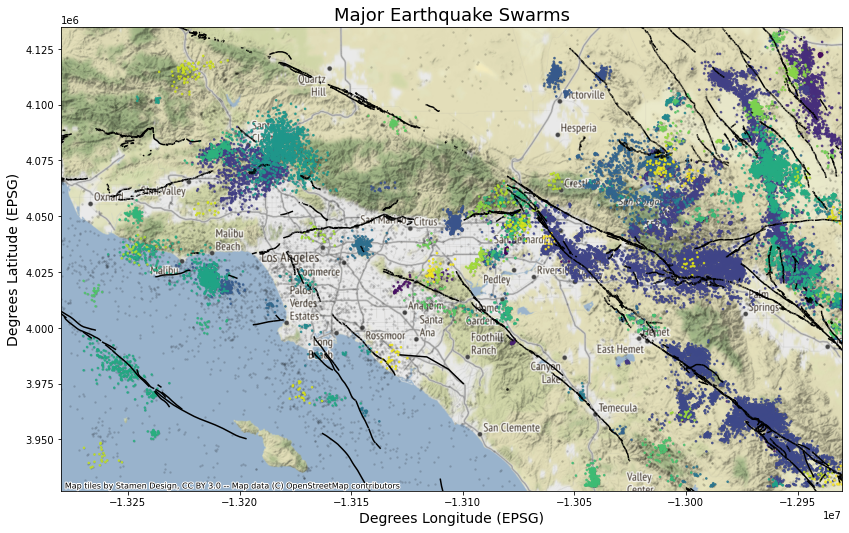

In [10]:
locmag = locmag.to_crs(epsg=3857)
base = locmag.plot(marker='.',markersize=10,c='k',figsize=(14,10),alpha=0.1)
locmag[locmag['label']!=-1].plot(ax=base,column='label',marker='.',markersize=10,cmap='viridis',alpha=0.8)
plt.title('Major Earthquake Swarms',fontsize=18)
plt.xlabel('Degrees Longitude (EPSG)',fontsize=14)
plt.ylabel('Degrees Latitude (EPSG)',fontsize=14)
ctx.add_basemap(base)
faults.plot(ax=base,color='k',label='Active Fault')
plt.xlim(-1.328e7,-1.293e7)
plt.ylim(3.927e6,4.135e6)
#plt.savefig('./plots/eq_swarm_map.png',dpi=235,bbox_inches='tight');

### Generate swarm plot with center locations

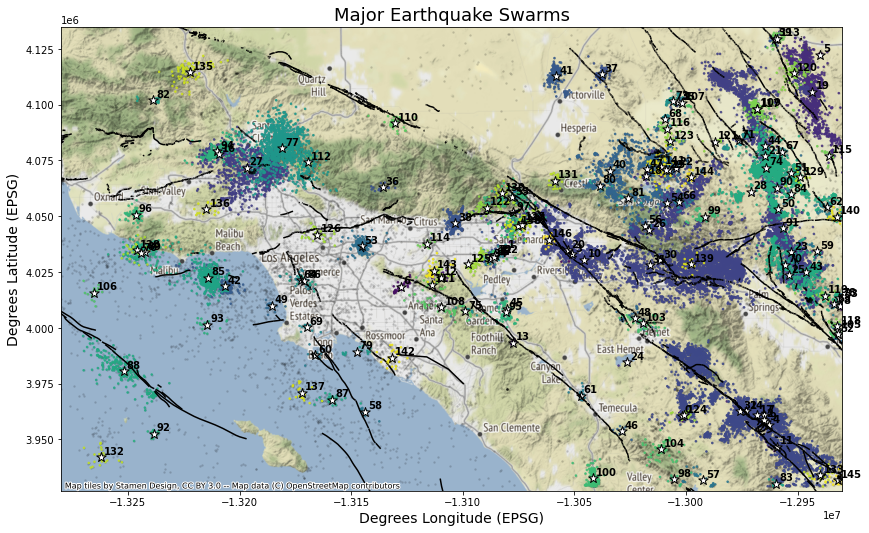

In [11]:
locmag = locmag.to_crs(epsg=3857)
base = locmag.plot(marker='.',markersize=10,c='k',figsize=(14,10),alpha=0.1)
locmag[locmag['label']!=-1].plot(ax=base,column='label',marker='.',markersize=10,cmap='viridis',alpha=0.8)
centers.plot(ax=base,marker='*',markersize=100,facecolor='w',edgecolor='k',label='Cluster Centers')
plt.title('Major Earthquake Swarms',fontsize=18)
plt.xlabel('Degrees Longitude (EPSG)',fontsize=14)
plt.ylabel('Degrees Latitude (EPSG)',fontsize=14)
ctx.add_basemap(base)
faults.plot(ax=base,color='k',label='Active Fault')
plt.xlim(-1.328e7,-1.293e7)
plt.ylim(3.927e6,4.135e6)
for x, y, label in zip(centers.geometry.x, centers.geometry.y, centers.label):
    base.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points",fontsize=10,fontweight='bold')
#plt.savefig('./plots/eq_swarm_map_labeled.png',dpi=235,bbox_inches='tight');

### Time distribution analysis of swarms

In [12]:
label_no = []
mean_age = []
stdv_age = []
num_eqs = []

for label in locmag['label']:
    label_no.append(label)
    mean_age.append(locmag[locmag['label']==label]['age'].mean()/365)
    stdv_age.append(locmag[locmag['label']==label]['age'].std()/365)
    num_eqs.append(locmag[locmag['label']==label].shape[0])

swarms = pd.DataFrame({'swarm':label_no,'mean_age':mean_age,'stdv_age':stdv_age,'count':num_eqs})

years = []
no_eqs = []
mean_mag = []

for year in locmag['year'].value_counts().index:
    years.append(year)
    mean_mag.append(locmag[locmag['year']==year]['mag'].mean()/365)
    no_eqs.append(locmag[locmag['year']==year].shape[0]) 
    
years = pd.DataFrame({'year':year,'count':no_eqs,'mean_mag':mean_mag})

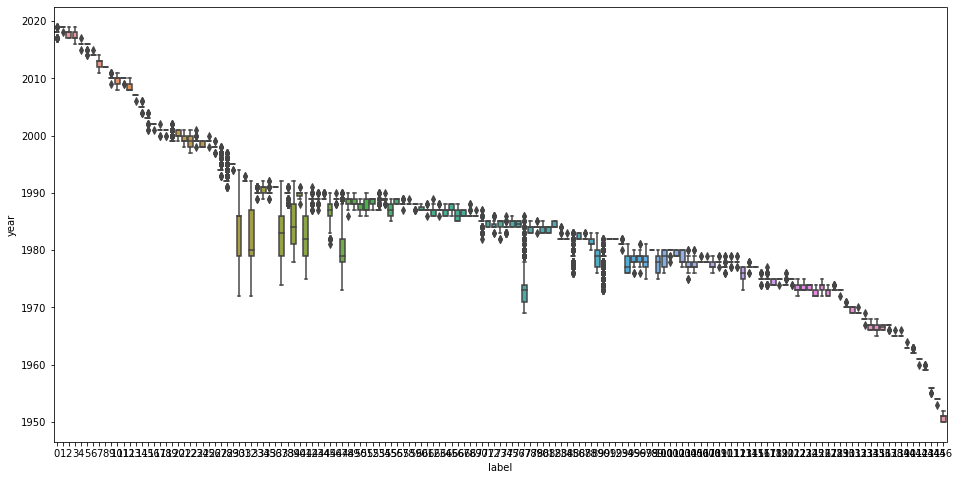

In [13]:
plt.figure(figsize=(16,8))
sns.boxplot(x="label", y="year", data=locmag[locmag['label']!=-1]);
#plt.savefig('./plots/eq_swarm_box.png',dpi=235,bbox_inches='tight');

In [14]:
cluster = []
year_std = []
year_mean = []

for label in locmag['label'].value_counts().index:
    cluster.append(label)
    year_mean.append(locmag[locmag['label']==label]['year'].mean())
    year_std.append(locmag[locmag['label']==label]['year'].std())

In [15]:
cluster_year = pd.DataFrame({'cluster':cluster,'year_mean':year_mean,'year_std':year_std})
cluster_year.sort_values('year_std',ascending=False)[1:11]

cluster    year_mean  year_std
2        32  1982.366884  4.678975
1        30  1983.306316  4.508790
9        41  1982.489595  4.083309
10       37  1982.531605  3.919986
22       39  1984.493671  3.693249
5        47  1980.039776  3.566310
6        77  1973.620040  3.139888
21       45  1986.917582  2.128164
24       89  1978.914729  1.820161
16       94  1977.502326  1.620183

### Anza-Borrego subregion analysis

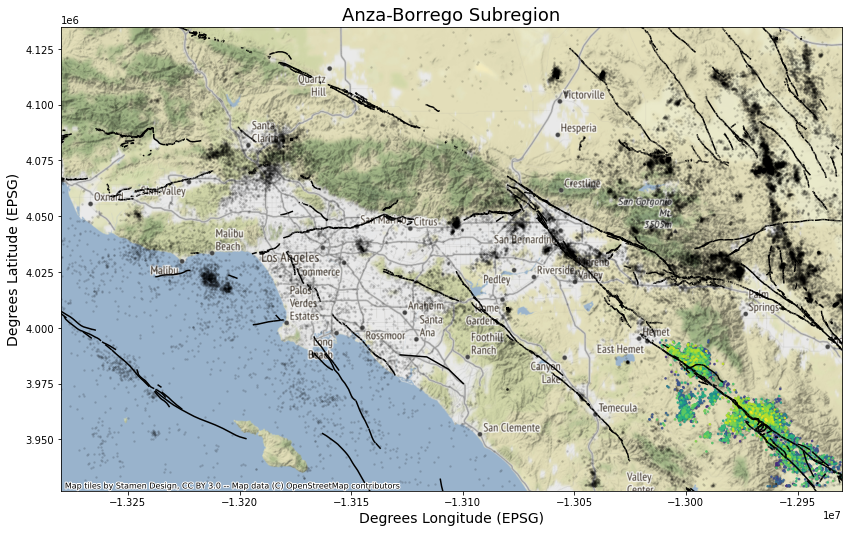

In [16]:
sub1 = locmag[locmag['label']==32]

locmag = locmag.to_crs(epsg=3857)
base = locmag.plot(marker='.',markersize=10,c='k',figsize=(14,10),alpha=0.1)
locmag[locmag['label']==32].plot(ax=base,column='age',marker='.',markersize=10,cmap='viridis',alpha=0.8)
plt.title('Anza-Borrego Subregion',fontsize=18)
plt.xlabel('Degrees Longitude (EPSG)',fontsize=14)
plt.ylabel('Degrees Latitude (EPSG)',fontsize=14)
ctx.add_basemap(base)
faults.plot(ax=base,color='k',label='Active Fault')
plt.xlim(-1.328e7,-1.293e7)
plt.ylim(3.927e6,4.135e6);
#plt.savefig('./plots/ab_swarm_map.png',dpi=235,bbox_inches='tight');

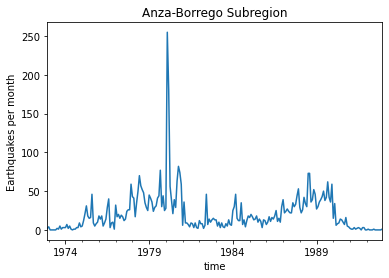

In [17]:
sub1['count'] = np.ones(sub1.shape[0])
sub1['time'] = pd.to_datetime(sub1['time'])
sub1.set_index('time', inplace=True)
sub1.resample('m').sum()['count'].plot();
plt.ylabel('Earthquakes per month')
plt.title('Anza-Borrego Subregion');
#plt.savefig('./plots/ab_swarm_ts.png',dpi=235,bbox_inches='tight');

### San Bernardino subregion

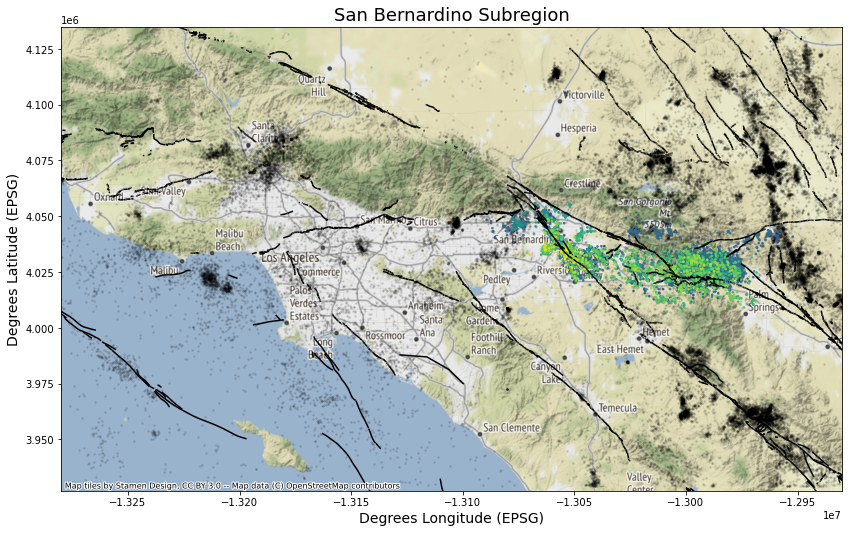

In [18]:
sub1 = locmag[locmag['label']==30]

locmag = locmag.to_crs(epsg=3857)
base = locmag.plot(marker='.',markersize=10,c='k',figsize=(14,10),alpha=0.1)
locmag[locmag['label']==30].plot(ax=base,column='age',marker='.',markersize=10,cmap='viridis',alpha=0.8)
plt.title('San Bernardino Subregion',fontsize=18)
plt.xlabel('Degrees Longitude (EPSG)',fontsize=14)
plt.ylabel('Degrees Latitude (EPSG)',fontsize=14)
ctx.add_basemap(base)
faults.plot(ax=base,color='k',label='Active Fault')
plt.xlim(-1.328e7,-1.293e7)
plt.ylim(3.927e6,4.135e6);
#plt.savefig('./plots/sb_swarm_map.png',dpi=235,bbox_inches='tight');

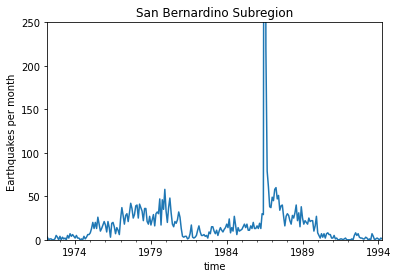

In [19]:
sub1['count'] = np.ones(sub1.shape[0])
sub1['time'] = pd.to_datetime(sub1['time'])
sub1.set_index('time', inplace=True)
sub1.resample('m').sum()['count'].plot();
plt.ylabel('Earthquakes per month')
plt.title('San Bernardino Subregion')
plt.ylim(0,250)
#plt.savefig('./plots/sb_swarm_ts.png',dpi=235,bbox_inches='tight');

### Big Bear Subregion

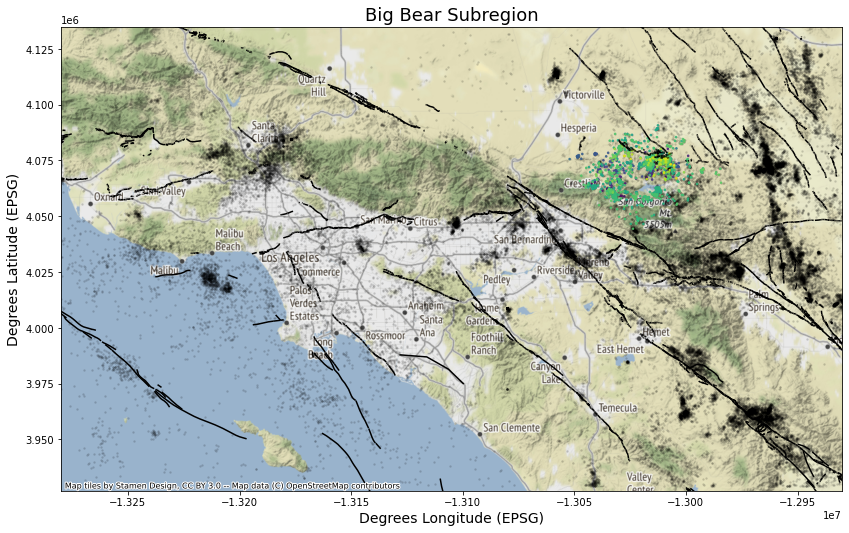

In [20]:
sub1 = locmag[locmag['label']==47]

locmag = locmag.to_crs(epsg=3857)
base = locmag.plot(marker='.',markersize=10,c='k',figsize=(14,10),alpha=0.1)
locmag[locmag['label']==47].plot(ax=base,column='age',marker='.',markersize=10,cmap='viridis',alpha=0.8)
plt.title('Big Bear Subregion',fontsize=18)
plt.xlabel('Degrees Longitude (EPSG)',fontsize=14)
plt.ylabel('Degrees Latitude (EPSG)',fontsize=14)
ctx.add_basemap(base)
faults.plot(ax=base,color='k',label='Active Fault')
plt.xlim(-1.328e7,-1.293e7)
plt.ylim(3.927e6,4.135e6);
#plt.savefig('./plots/la_quakes.png',dpi=235,bbox_inches='tight');

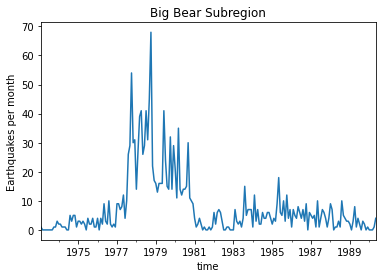

In [21]:
sub1['count'] = np.ones(sub1.shape[0])
sub1['time'] = pd.to_datetime(sub1['time'])
sub1.set_index('time', inplace=True)
sub1.resample('m').sum()['count'].plot();
plt.ylabel('Earthquakes per month')
plt.title('Big Bear Subregion')
#plt.savefig('./plots/bb_swarm_ts.png',dpi=235,bbox_inches='tight');

### Write swarm data to file

In [22]:
locmag[locmag['label']!=-1][['latitude','longitude','depth','mag','year','age','label','geometry']].to_file('datasets/eq_swarm.shp')
centers.to_file('datasets/eq_swarm_centers.shp')